# Summaries

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_ns = [200, 500, 1000, 10000, 50000]
all_ps = [5, 10, 100, 200]

select_ns = [200]
select_ps = all_ps

train_summaries_dfs = {}
validation_summaries_dfs = {}
for n in all_ns:
    for p in select_ps:
        
#         if n not in select_ns or sd not in select_sds:
#             continue
            
        train_filename = f'train_summary_p_{p}_n_{n}.csv'
        train_df = pd.read_csv(train_filename, index_col=0)
        train_df['n'] = n
        train_df['sd'] = p

        validation_filename = f'validation_summary_p_{p}_n_{n}.csv'
        validation_df = pd.read_csv(validation_filename, index_col=0)
        validation_df['n'] = n
        validation_df['p'] = p
        
        train_summaries_dfs[f'n:{n}, p:{p}'] = train_df
        validation_summaries_dfs[f'n:{n}, p:{p}'] = validation_df

In [123]:
all_train_summaries_df = pd.concat(train_summaries_dfs.values(), axis=0).reset_index()
all_train_summaries_df.columns = ['model'] + list(all_train_summaries_df.columns[1:])
all_validation_summaries_df = pd.concat(validation_summaries_dfs.values(), axis=0).reset_index()
all_validation_summaries_df.columns = ['model'] + list(all_validation_summaries_df.columns[1:])

In [124]:
#all_validation_summaries_df

# Predictions

In [125]:
import pickle

all_ns = [200, 500, 1000, 10000, 50000]
all_ps = [5, 10, 100, 200]

select_ns = [200]
select_ps = all_ps

preds_pkls = {}
for n in all_ns:
    for p in all_ps:
        
#         if n not in select_ns or sd not in select_sds:
#             continue
            
        filename = f'preds_dict_train_n_{n}_p_{p}.pkl'
        with open(filename, 'rb') as handle:
            preds_pkl = pickle.load(handle)
            preds_pkls[f'n:{n}, p:{p}'] = preds_pkl

In [126]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy
import warnings

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

KEY_GENERATED_DATA = "generated_data"
KEY_ACTUAL = "Actuals"

RANDOM_SEED = 42
LOAD_DATA = False

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def distr_plot_single_sim(
    synthetic_preds,
    savepath,
    kind="kde",
    include_learners=[],
    bins=50,
    histtype="step",
    alpha=1,
    linewidth=1,
    bw_method=1,
    title = "Distribution from a Single Simulation"
):
    """Plots the distribution of each learner's predictions (for a single simulation).
    Kernel Density Estimation (kde) and actual histogram plots supported.
    Args:
        synthetic_preds (dict): dictionary of predictions generated by get_synthetic_preds()
        kind (str, optional): 'kde' or 'hist'
        drop_learners (list, optional): list of learners (str) to omit when plotting
        bins (int, optional): number of bins to plot if kind set to 'hist'
        histtype (str, optional): histogram type if kind set to 'hist'
        alpha (float, optional): alpha (transparency) for plotting
        linewidth (int, optional): line width for plotting
        bw_method (float, optional): parameter for kde
    """
    
    learners = include_learners
    cmap = get_cmap(len(learners) + 1)
    preds_for_plot = {}
    for l in learners:
        preds_for_plot[l] = synthetic_preds[l]

    
    # deleted generated data and assign actual value
    del preds_for_plot[KEY_GENERATED_DATA]
    global_lower = np.percentile(np.hstack(preds_for_plot.values()), 1)
    global_upper = np.percentile(np.hstack(preds_for_plot.values()), 99)

    # Plotting
    plt.figure(figsize=(12, 8))
    for i, (k, v) in enumerate(preds_for_plot.items()):
        if k in learners:
            if kind == "kde":
                v = pd.Series(v.flatten())
                v = v[v.between(global_lower, global_upper)]
                v.plot(
                    kind="kde",
                    bw_method=bw_method,
                    label=k,
                    linewidth=linewidth,
                    color=cmap(i),
                )
            elif kind == "hist":
                plt.hist(
                    v,
                    bins=np.linspace(global_lower, global_upper, bins),
                    label=k,
                    histtype=histtype,
                    alpha=alpha,
                    linewidth=linewidth,
                    color=cmap(i),
                )
            else:
                pass

    plt.xlim(global_lower, global_upper)
    #plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.xlabel("Abs % Error of ATE")
    plt.legend()
    plt.title(title)
    plt.savefig(savepath)

def plot_dist(dictionary, linear_models, save_path, alpha = 0.2, bins = 30):
    plt.figure(figsize=(12,8))
    keys = dictionary.keys()
    lin_models = linear_models
    not_lin_models = [key for key in keys if key not in linear_models]
    for k in not_lin_models:
        values = dictionary[k]
        plt.hist(values, alpha = alpha, bins = bins, label = k, range=[-0.5, 2])
    for k in lin_models:
        values = dictionary[k]
        plt.axvline(values[0], label=k,
           linestyle='dotted', color=np.random.rand(3,), linewidth=2)
    plt.title('Distribution of CATE Predictions by Meta Learner')
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    plt.legend(fontsize=12)
    plt.savefig(save_path)

def scatter_plot_summary(synthetic_summary, savepath, k, drop_learners=[], drop_cols=[]):
    """Generates a scatter plot comparing learner performance. Each learner's performance is plotted as a point in the
    (Abs % Error of ATE, MSE) space.
    Args:
        synthetic_summary (pd.DataFrame): summary generated by get_synthetic_summary()
        k (int): number of simulations (used only for plot title text)
        drop_learners (list, optional): list of learners (str) to omit when plotting
        drop_cols (list, optional): list of metrics (str) to omit when plotting
    """
    plot_data = synthetic_summary.drop(drop_learners).drop(drop_cols, axis=1)

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    xs = plot_data["Abs % Error of ATE"]
    ys = plot_data["MSE"]

    ax.scatter(xs, ys)

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    for i, txt in enumerate(plot_data.index):
        ax.annotate(
            txt,
            (
                xs[i] - np.random.binomial(1, 0.5) * xlim[1] * 0.04,
                ys[i] - ylim[1] * 0.03,
            ),
        )

    ax.set_xlabel("Abs % Error of ATE")
    ax.set_ylabel("MSE")
    ax.set_title("Learner Performance (averaged over k={} simulations)".format(k))
    plt.savefig(savepath)

def scatter_plot_summary_holdout(
    train_summary,
    validation_summary,
    k,
    savepath,
    label=["Train", "Validation"],
    drop_learners=[],
    drop_cols=[],
):
    """Generates a scatter plot comparing learner performance by training and validation.
    Args:
        train_summary (pd.DataFrame): summary for training synthetic data generated by get_synthetic_summary_holdout()
        validation_summary (pd.DataFrame): summary for validation synthetic data generated by
            get_synthetic_summary_holdout()
        label (string, optional): legend label for plot
        k (int): number of simulations (used only for plot title text)
        drop_learners (list, optional): list of learners (str) to omit when plotting
        drop_cols (list, optional): list of metrics (str) to omit when plotting
    """
    train_summary = train_summary.drop(drop_learners).drop(drop_cols, axis=1)
    validation_summary = validation_summary.drop(drop_learners).drop(drop_cols, axis=1)

    plot_data = pd.concat([train_summary, validation_summary])
    plot_data["label"] = [i.replace("Train", "") for i in plot_data.index]
    plot_data["label"] = [i.replace("Validation", "") for i in plot_data.label]

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    xs = plot_data["Abs % Error of ATE"]
    ys = plot_data["MSE"]
    group = np.array(
        [label[0]] * train_summary.shape[0] + [label[1]] * validation_summary.shape[0]
    )
    cdict = {label[0]: "red", label[1]: "blue"}

    for g in np.unique(group):
        ix = np.where(group == g)[0].tolist()
        ax.scatter(xs[ix], ys[ix], c=cdict[g], label=g, s=100)

    for i, txt in enumerate(plot_data.label[:10]):
        ax.annotate(txt, (xs[i] + 0.005, ys[i]))

    ax.set_xlabel("Abs % Error of ATE")
    ax.set_ylabel("MSE")
    ax.set_title("Learner Performance (averaged over k={} simulations)".format(k))
    ax.legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
    plt.savefig(savepath)

def bar_plot_summary_holdout(
    train_summary, validation_summary, k, savepath, drop_learners=[], drop_cols=[]
):
    """Generates a bar plot comparing learner performance by training and validation
    Args:
        train_summary (pd.DataFrame): summary for training synthetic data generated by get_synthetic_summary_holdout()
        validation_summary (pd.DataFrame): summary for validation synthetic data generated by
            get_synthetic_summary_holdout()
        k (int): number of simulations (used only for plot title text)
        drop_learners (list, optional): list of learners (str) to omit when plotting
        drop_cols (list, optional): list of metrics (str) to omit when plotting
    """
    train_summary = train_summary.drop([KEY_ACTUAL])
    train_summary["Learner"] = train_summary.index

    validation_summary = validation_summary.drop([KEY_ACTUAL])
    validation_summary["Learner"] = validation_summary.index

    for metric in ["Abs % Error of ATE", "MSE", "KL Divergence"]:
        plot_data_sub = pd.DataFrame(train_summary.Learner).reset_index(drop=True)
        plot_data_sub["train"] = train_summary[metric].values
        plot_data_sub["validation"] = validation_summary[metric].values
        plot_data_sub = plot_data_sub.set_index("Learner")
        plot_data_sub = plot_data_sub.drop(drop_learners).drop(drop_cols, axis=1)
        plot_data_sub = plot_data_sub.sort_values("train", ascending=True)

        plot_data_sub.plot(kind="bar", color=["red", "blue"], figsize=(12, 8))
        plt.xticks(rotation=30)
        plt.title(
            "Learner Performance of {} (averaged over k={} simulations)".format(
                metric, k
            )
        )
        plt.savefig(savepath)


In [127]:
#For non-ensemble algo, 1 boosting + 1 bagging algo, give a heatmap across size/covariates (with values present)
    # non-ensemble algo: X Learner (XGB)
    # boosting algo: S Learner (Adaboost_SVR)
    # bagging algo: S Learner (Bagging_SVR)


#things to try plotting:
    #distribution of algos at a small size vs. big size

In [128]:
mdl_name = 'S Learner (Bagging_SVR)'
temp = all_validation_summaries_df[all_validation_summaries_df['model'] == mdl_name]
temp

,model,Abs % Error of ATE,MSE,KL Divergence,n,p
4,S Learner (Bagging_SVR),0.013235,0.194616,2.480107,200,5
23,S Learner (Bagging_SVR),0.635481,0.259127,2.493996,200,10
42,S Learner (Bagging_SVR),0.388285,0.083836,3.915796,200,100
61,S Learner (Bagging_SVR),0.685229,0.186311,4.254805,200,200
80,S Learner (Bagging_SVR),0.040856,0.134814,0.941662,500,5
99,S Learner (Bagging_SVR),0.373616,0.120260,1.340349,500,10
118,S Learner (Bagging_SVR),0.016533,0.048734,1.357392,500,100
137,S Learner (Bagging_SVR),0.456717,0.084910,2.537843,500,200
156,S Learner (Bagging_SVR),0.004915,0.090508,0.752573,1000,5
175,S Learner (Bagging_SVR),0.154223,0.085687,0.613710,1000,10


<class 'matplotlib.axes._subplots.AxesSubplot'>


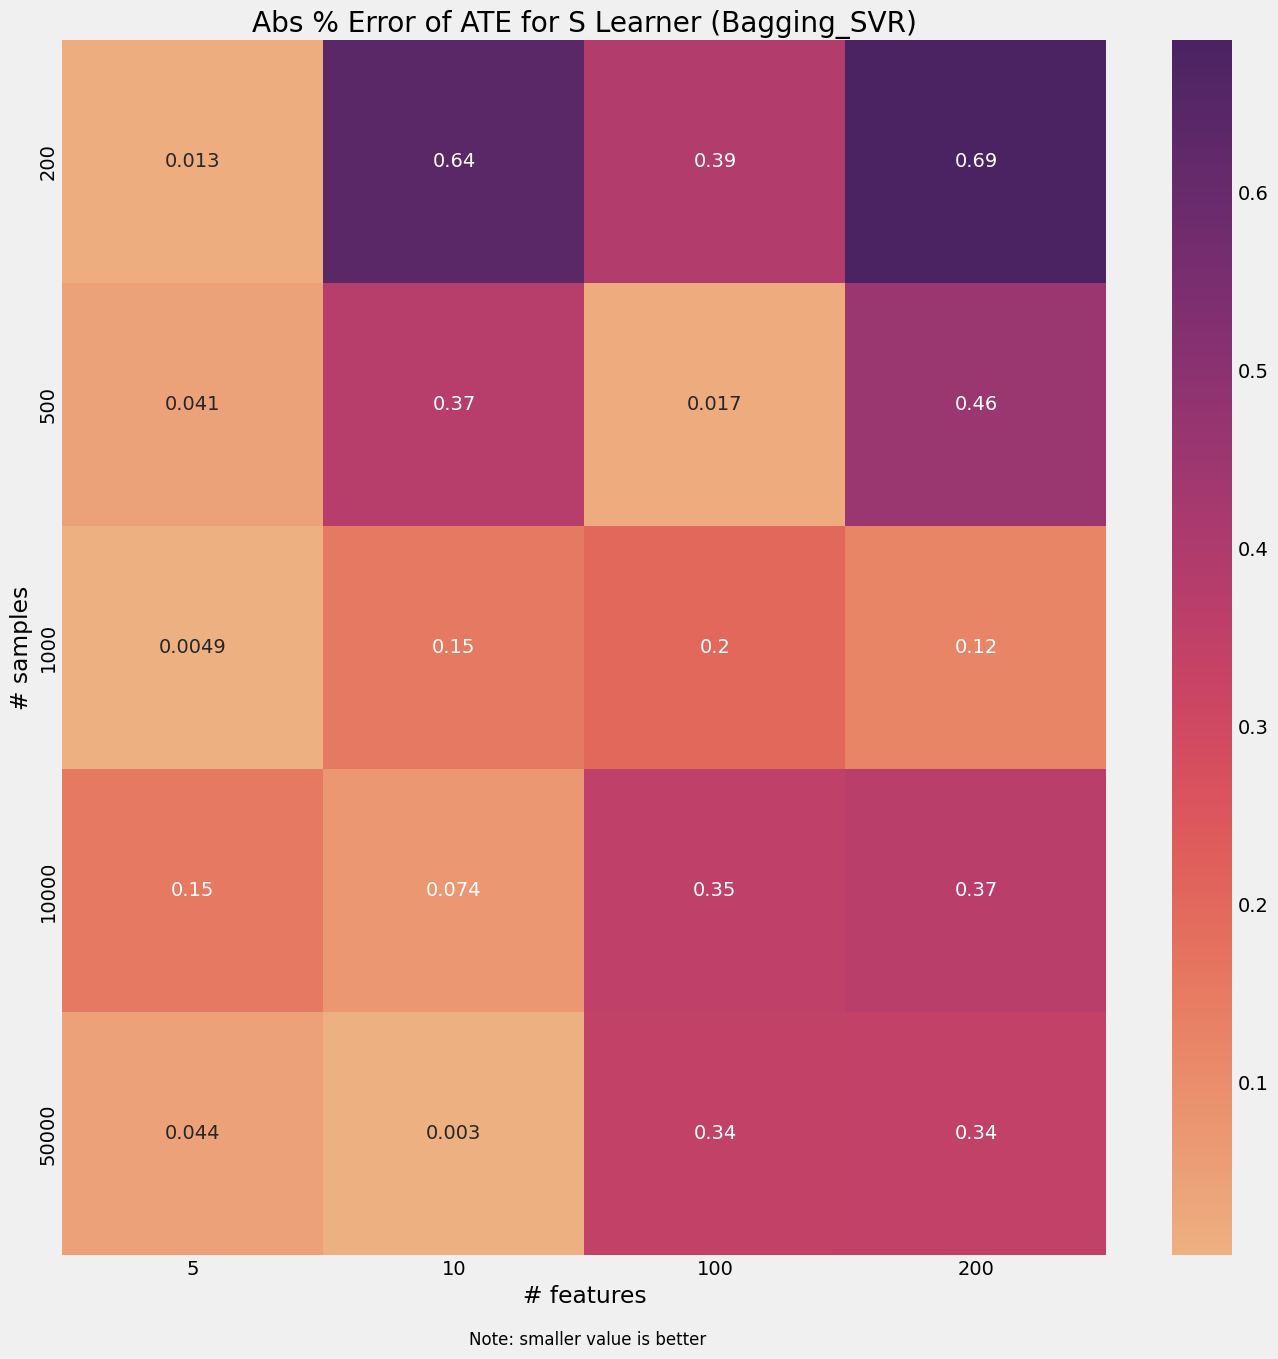

In [129]:
plt.figure(figsize=(15, 15))
temp2 = temp[['Abs % Error of ATE','n','p']].pivot('n','p','Abs % Error of ATE').rename_axis(['# samples']).rename_axis(['# features'], axis = 1)
fig = sns.heatmap(temp2, cmap=sns.color_palette("flare", as_cmap=True), annot = True)

plt.title(f'Abs % Error of ATE for {mdl_name}')
plt.figtext(0.43, 0.01, 'Note: smaller value is better', wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'heatmap_{mdl_name}.png', dpi = 320)

In [ ]:
#X Learner (XGB)

"\ndistr_plot_single_sim(\n    synthetic_preds = preds_pkls[f'n:{n}, p:{5}'],\n    savepath = 'temp.png',\n    include_learners = include_learners + ['generated_data'] + ['Actuals'],\n    title = 'CATE Distribution of Non-Ensemble Distributions'\n)\n"

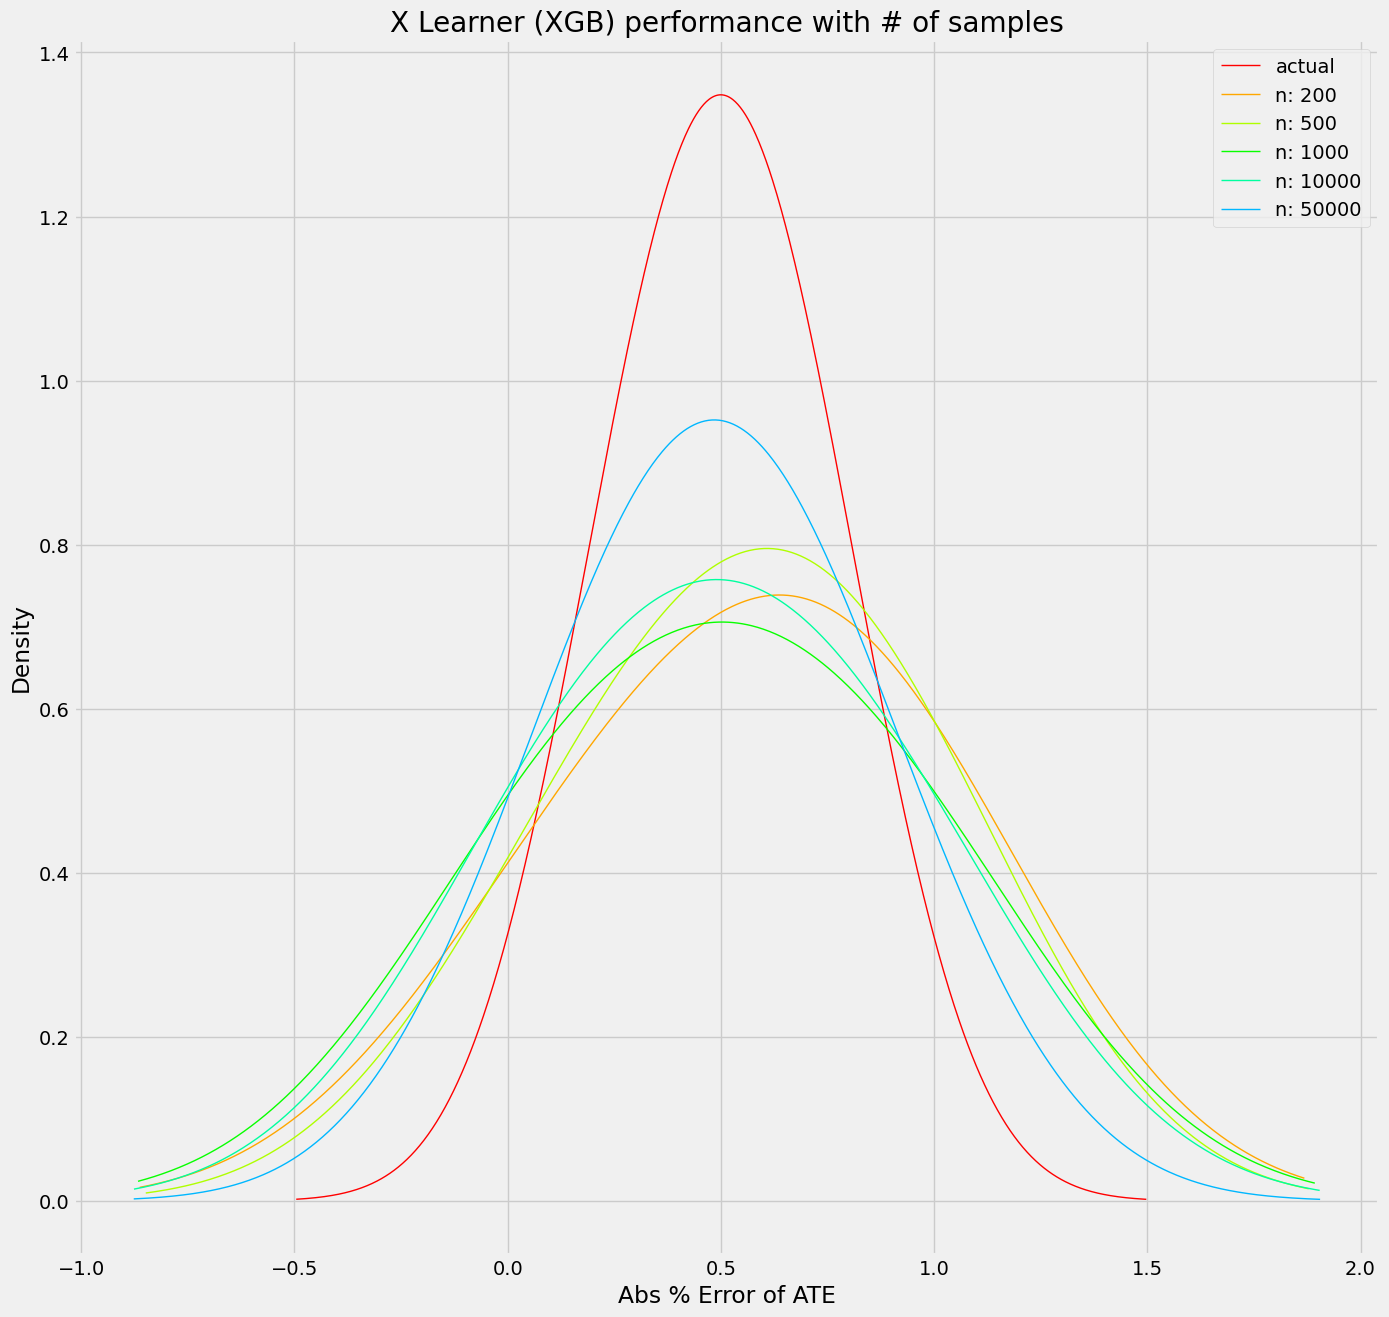

In [130]:
n,p = 50000,5
to_plot = ['Actuals', 'X Learner (XGB)']
dist_keys = preds_pkls[f'n:{n}, p:{p}'].keys()
include_learners = [s for s in dist_keys if s in to_plot]

alpha=1
linewidth=1
bw_method=1

cmap = get_cmap(10)
temp = np.hstack(preds_pkls[f'n:{n}, p:{p}'].values())
temp = pd.to_numeric(temp, errors='coerce')
temp = temp[~np.isnan(temp)]
global_lower = np.percentile(temp, 1)
global_upper = np.percentile(temp, 99)

all_ns = [200, 500, 1000, 10000, 50000]
all_ps = [5, 10, 100, 200]


plt.figure(figsize=(15, 15))
v = pd.Series(preds_pkls[f'n:{n}, p:{p}']['Actuals'])
v = v[v.between(global_lower, global_upper)]
v.plot(
    kind="kde",
    bw_method=bw_method,
    label='actual',
    linewidth=linewidth,
    color=cmap(0),
)

i = 1
p = 10
for n in all_ns:
    v = preds_pkls[f'n:{n}, p:{p}']['X Learner (XGB)']
    v = pd.Series(v.flatten())
    v = v[v.between(global_lower, global_upper)]
    v.plot(
        kind="kde",
        bw_method=bw_method,
        label= f'n: {n}',
        linewidth=linewidth,
        color=cmap(i),
    )
    i += 1

plt.legend()
plt.title("X Learner (XGB) performance with # of samples")
plt.xlabel("Abs % Error of ATE")
plt.savefig('xg_boost_performance.png', dpi = 320)
"""
distr_plot_single_sim(
    synthetic_preds = preds_pkls[f'n:{n}, p:{5}'],
    savepath = 'temp.png',
    include_learners = include_learners + ['generated_data'] + ['Actuals'],
    title = 'CATE Distribution of Non-Ensemble Distributions'
)
"""

760001